<div class="alert alert-success">
    <center> <h1> <font size="8"> Multivariate Normal Example </font> </h1> </center>
    <center> <h1> <font size="5"> Low-Rank Approximation of $\Sigma$  </font> </h1> </center>
</div>

<br/>
<br/>

In this example, we model and predict all parameters of a trivariate ($Y_{D}=3$) Normal distribution. The conditional means $\mathbf{\mu}(x) \in \mathbb{R}^{D}$ and the conditional covariance matrix $\mathbf{\Sigma}(x) \in \mathbb{R}^{D \times D}$ are given as follows

$$
\mathbf{\mu}(x)=\begin{pmatrix}\mu_{1}(x) \\ \mu_{2}(x) \\ \mu_{3}(x)\end{pmatrix}, \qquad \qquad  
\mathbf{\Sigma}(x)= \begin{pmatrix}
\sigma^{2}_{11}(x) & \rho_{1,2}(x)\sigma_{1}(x)\sigma_{2}(x) & \rho_{1,3}(x)\sigma_{1}(x)\sigma_{3}(x) \\
\rho_{2,1}(x)\sigma_{2}(x)\sigma_{1}(x) & \sigma^{2}_{22}(x) & \rho_{2,3}(x)\sigma_{2}(x)\sigma_{3}(x) \\
\rho_{3,1}(x)\sigma_{3}(x)\sigma_{1}(x) & \rho_{3,2}(x)\sigma_{3}(x)\sigma_{2}(x) &  \sigma^{2}_{33}(x)
\end{pmatrix}
$$

While efficient for low to medium dimensions of $D$, the computational cost of the Cholesky-decomposition becomes prohibitive in high-dimensional settings. To reduce the computational overhead, the covariance matrix $\mathbf{\Sigma}$ can be approximated via the sum of a diagonal matrix $\mathbf{K} \in \mathbb{R}^{D \times D}_{+}$ and a unrestricted low-rank matrix $\mathbf{V} \in \mathbb{R}^{D \times r}$ 

$$
\begin{align}
\mathbf{\Sigma} &= \mathbf{K} + \mathbf{V}\mathbf{V}^{T}  \\
                  &= \begin{bmatrix}
                   \exp(\text{K}_{1}) & \dots  & 0\\
                  \vdots & \ddots & \vdots\\
                  0 & \dots  & \exp(\text{K}_{D})
                  \end{bmatrix} + 
                  \begin{bmatrix}
                   \text{V}_{1}  \\
                   \vdots  \\
                   \text{V}_{D} \\
                   \end{bmatrix} 
                  \begin{bmatrix}
                   \text{V}_{1}  \\
                   \vdots  \\
                   \text{V}_{D} \\
                  \end{bmatrix}^{T}
\end{align}
$$

where $\exp(\cdot)$ ensures all diagonal entries of $\mathbf{K}$ to be strictly positive and the rank parameter $r$ governs the quality of the approximation. The computational efficiency of this approach results from the fact that the rank parameter $r<\!\!<D$ can typically be chosen much smaller than the number of target variables $D$. The following table shows the number of parameters $K$ to estimate for a Multivariate Gaussian for the Cholesky $D(D+3)/2$ and the low-rank covariance matrix approximation $D(2+r)$ as functions of the response dimension $\mbox{Y}_{D}$.

<center>

| $\mbox{Y}_{D}$  | Cholesky     |  LRA(r=5)  | LRA(r=10)   | LRA(r=20)  |
|:---------------:|:------------:|:----------:|:-----------:|:----------:|
|        2        | 5            | 14         | 24          | 44         |
|        5        | 20           | 35         | 60          | 110        |
|       10        | 65           | 70         | 120         | 220        |
|       50        | 1,325        | 350        | 600         | 1,100      |
|       100       | 5,150        | 700        | 1,200       | 2,200      |
|       500       | 125,750      | 3,500      | 6,000       | 11,000     |
|      1,000      | 501,500      | 7,000      | 12,000      | 22,000     |
|     10,000      | 50,015,000   | 70,000     | 120,000     | 220,000    |

</center>

The table shows that the number of parameters increases exponentially for the Cholesky-decomposition, while the relationship is only linear for the low-rank approximation, making it more suitable for high-dimensional settings. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

<br>
<br>

# Imports

In [3]:
import os
import numpy as np
import pandas as pd
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pyboostlss.model import *
from pyboostlss.distributions.MVN_LRA import *
from pyboostlss.distributions.distribution_loss_metric import *
from pyboostlss.utils import *
from pyboostlss.datasets.data_loader import load_example_data

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Specifiy distribution and initialize model

In [7]:
distribution = MVN_LRA(r=1,D=3)           # Multivariate Normal distribution, where r specifies the rank and D specifies the number of target variables. In this example, r is chosen arbitrarily low and should rather be included in the hyper-parameter search
pyblss = PyBoostLSS(distribution)         # Initializes model with specified distribution

# Data

In [8]:
data_sim = load_example_data("sim_triv_gaussian.csv")

# Create 60%, 20%, 20% split for train, validation and test 
train, validate, test = np.split(data_sim.sample(frac=1,random_state=123), [int(0.6*len(data_sim)), int(0.8*len(data_sim))])

# Train
x_train = train["x"].values.reshape(-1,1)
y_train = train.filter(regex="y").values
dtrain = {"X": x_train, "y": y_train}

# Validation
x_eval = validate["x"].values.reshape(-1,1)
y_eval = validate.filter(regex="y").values
eval_sets = [{'X': x_eval, 'y': y_eval}] # Specifies eval_sets on which the model is evaluated on

# Test
x_test = test["x"].values.reshape(-1,1)
y_test = test.filter(regex="y").values

# Hyper-Parameter Optimization via Optuna

In [9]:
np.random.seed(123)

# Specifies the hyper-parameters and their value range
    # The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]
    # Currently, only the following hyper-parameters can be optimized
    
hp_dict = {"lr": [1e-3, 1],  
           "max_depth": [1, 4],
           "sketch_outputs": [1,10],
           "lambda_l2": [0, 40],     
           "colsample": [0.2, 1.0],
           "subsample": [0.2, 1.0],
           "min_gain_to_split": [0, 500]
          }  

opt_param = pyblss.hyper_opt(params=hp_dict,
                             dtrain=dtrain,
                             eval_sets=eval_sets,
                             use_hess=True, 
                             sketch_method="proj",
                             hp_seed=123,                # Seed for random number generator used in the Bayesian hyper-parameter search.
                             ntrees=500,                 # Number of boosting iterations.
                             es=20,                      # Early stopping rounds
                             n_trials=50,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                             silence=False)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2022-12-14 15:32:19,120] A new study created in memory with name: Py-BoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\OneDrive - adidas\pyboostlss\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/50 [00:00<?, ?it/s]

[15:32:19] Stdout logging level is INFO.
[15:32:19] GDBT train starts. Max iter 500, early stopping rounds 20
[15:32:19] Iter 0; Sample 0, NLL-score = 9733.947265625; 
[15:32:24] Early stopping at iter 96, best iter 76, best_score 7232.9462890625
[I 2022-12-14 15:32:24,217] Trial 0 finished with value: 7232.9521484375 and parameters: {'lr': 0.6967727164122638, 'max_depth': 2, 'sketch_outputs': 3, 'lambda_l2': 22.05259076331565, 'colsample': 0.7755751758284506, 'subsample': 0.5384851680995688, 'min_gain_to_split': 490.38209919230775}. Best is trial 0 with value: 7232.9521484375.
[15:32:24] Stdout logging level is INFO.
[15:32:24] GDBT train starts. Max iter 500, early stopping rounds 20
[15:32:24] Iter 0; Sample 0, NLL-score = 9326.666015625; 
[15:32:28] Early stopping at iter 106, best iter 86, best_score 7214.31640625
[I 2022-12-14 15:32:29,073] Trial 1 finished with value: 7214.3154296875 and parameters: {'lr': 0.6851449088462784, 'max_depth': 2, 'sketch_outputs': 4, 'lambda_l2': 13.

# Model Training

In [10]:
opt_params = opt_param.copy()

pyboostlss_model = pyblss.train(dtrain=dtrain,
                                lr=opt_params["lr"], 
                                lambda_l2=opt_params["lambda_l2"],
                                max_depth=opt_params["max_depth"],
                                sketch_outputs=opt_params["sketch_outputs"],
                                colsample=opt_params["colsample"],
                                subsample=opt_params["subsample"],
                                min_gain_to_split=opt_params["min_gain_to_split"],
                                ntrees=opt_params["opt_rounds"],
                                use_hess=True,
                                verbose=100,
                                sketch_method="proj",
                                seed=123)

[15:42:24] Stdout logging level is INFO.
[15:42:24] GDBT train starts. Max iter 229, early stopping rounds 100
[15:42:24] Iter 0; 
[15:42:28] Iter 100; 
[15:42:32] Iter 200; 
[15:42:33] Iter 228; 


# Predict

In [11]:
# Predicts transformed parameters of the specified distribution. Py-BoostLSS returns the elements of the covariance matrix, instead of the LRA approximation.
predt_params = distribution.predict(model=pyboostlss_model,
                                    X_test=x_test,
                                    pred_type="parameters")
predt_params

,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_21,rho_31,rho_32
0,0.284456,1.132105,0.932534,0.633367,1.703143,1.219697,0.785458,0.569671,0.724965
1,-0.190135,0.437387,1.469268,0.685720,1.847979,1.759081,0.911476,0.650341,0.617580
2,0.597507,0.563761,1.846639,0.933210,1.699421,0.955674,0.716228,0.663967,0.476890
3,0.440862,0.618365,1.701601,0.893370,1.418496,0.960602,0.920102,0.639221,0.589979
4,0.153675,0.773769,1.845603,0.793714,1.574988,1.404505,0.775295,0.736230,0.572958
...,...,...,...,...,...,...,...,...,...
1995,0.036060,0.030536,0.998890,0.611919,1.023885,1.091487,0.910193,0.639209,0.701818
1996,-0.191115,0.471778,1.498609,0.697581,1.796792,1.740389,0.911919,0.650619,0.615301
1997,0.597507,0.563761,1.846639,0.933210,1.699421,0.955674,0.716228,0.663967,0.476890
1998,0.041179,1.374185,1.036362,0.595845,1.397619,1.340100,0.598576,0.417006,0.696172


In [12]:
# Draws random samples from the predicted distribution
torch.manual_seed(123)
n_samples = 10000
predt_samples = distribution.predict(model=pyboostlss_model,
                                     X_test=x_test,
                                     pred_type="samples",   
                                     n_samples=n_samples)

predt_samples.shape # Output-shape is (n_samples, n_obs, n_target)

(10000, 2000, 3)

# Plots

## Actual vs. Predicted Parameters

In the following figure, we compare the true parameters of the multivariate Gaussian with the ones predicted by Py-BoostLSS. The below figure shows that the estimated parameters of the multivariate Gaussian closely match the true ones, even with a rank as low as 1.

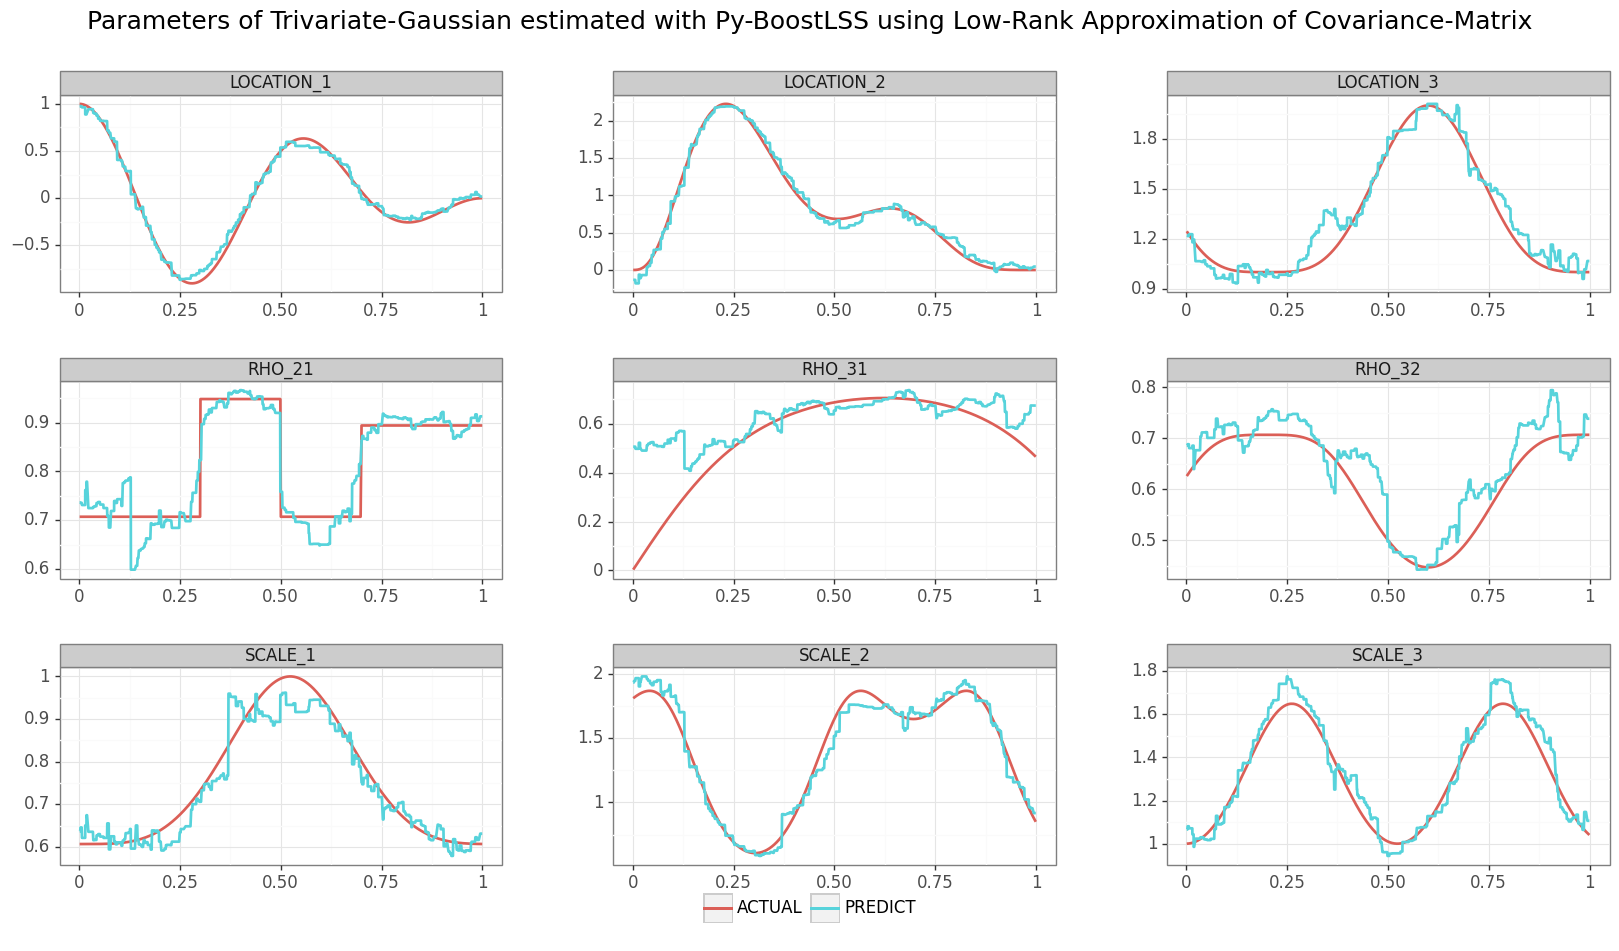

In [15]:
predt_params["x"] = x_test
dist_params = list(predt_params.columns)
drop_cols = [resp for resp in list(test.columns) if "y" in resp]

# Data with actual values
plot_df_actual = pd.melt(test.drop(columns=drop_cols, axis=0),
                         id_vars="x",
                         value_vars=dist_params)
plot_df_actual["type"] = "ACTUAL"

# Data with predicted values
plot_df_predt = pd.melt(predt_params,
                        id_vars="x",
                        value_vars=dist_params)
plot_df_predt["type"] = "PREDICT"

plot_df = pd.concat([plot_df_actual, plot_df_predt])   

plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          scales="free") + 
               labs(title="Parameters of Trivariate-Gaussian estimated with Py-BoostLSS using Low-Rank Approximation of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank(),
                     subplots_adjust={"wspace": 0.25,
                                      "hspace": 0.45})
              )


print(plot_params)

## Actuals vs. Predicted

Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest.

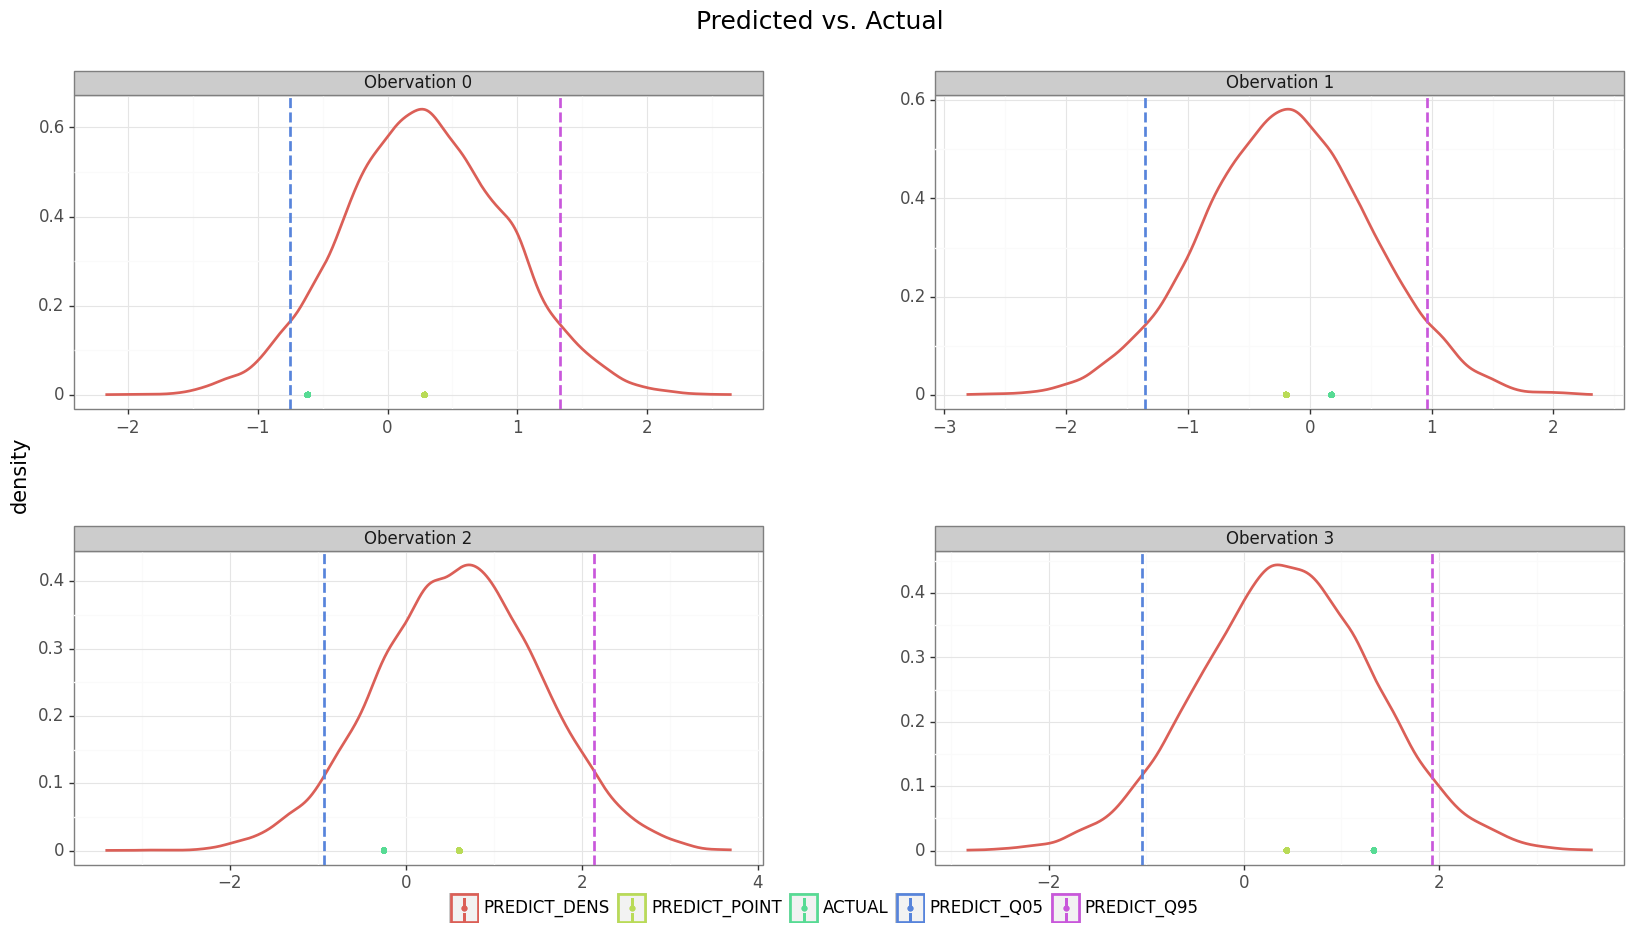

In [16]:
n_examples = 4
q_sel = [0.05, 0.95]

y_pred = []

for i in range(n_examples):
    
    y_samples = pd.DataFrame(predt_samples[:,i,0].reshape(-1,1), columns=["PREDICT_DENS"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENS"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i,0]
    y_samples["obs"]= f"Obervation {i}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free") + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank(),
          subplots_adjust={"wspace": 0.25,
                           "hspace": 0.45})
)

print(plot_pred)